Necessary imports and settings

In [1]:
import glob
from PIL import Image
import numpy as np
import tensorflow as tf

dataFolder = "C:\\Users\\Aidan\\Desktop\\Code\\AI Robotics\\Project\\data"
# dataFolder = "C:\\Users\\ariel\\OneDrive - Kennesaw State University\\Graduate School\\Fall 2023\\CS 7050 - AI and Robotics\\Group Project\\GroupProject - GitRepo\\nyu_data\\data"
inputImageSize = (256, 256)

data_loading_percentage = 20
trainTestSplit = 90

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Add, Activation, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

Loading data

In [3]:
imageSequences = glob.glob(dataFolder + "\\nyu2_train\\*")

validIndices = []
imageCount = 0

for imageSequence in imageSequences[0:int(len(imageSequences)*(data_loading_percentage/100))]:
    inputImages = glob.glob(imageSequence + "\\*.jpg")
    [validIndices.append(imageCount+j) for j in range(2, len(inputImages))]
    imageCount += len(inputImages)

In [4]:
def sortImages(inputList):
    return [x for _, x in sorted(zip([int(input[input.rfind("\\") + 1:-4]) for input in inputList], inputList))]

def print_progress_bar(iteration, total, prefix='', suffix='', length=25, fill='█'):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
    # Print New Line on Complete
    if iteration == total-1: 
        print("\n")


imageData = np.empty((imageCount, inputImageSize[0], inputImageSize[1], 3), dtype='float32')
depthData = np.empty((imageCount, inputImageSize[0], inputImageSize[1]), dtype='float32')


imageSequences = glob.glob(dataFolder + "\\nyu2_train\\*")
index = 0

for i, imageSequence in enumerate(imageSequences[0:int(len(imageSequences)*(data_loading_percentage/100))]):
    inputImages = sortImages(glob.glob(imageSequence + "\\*.jpg"))
    depthImages = sortImages(glob.glob(imageSequence + "\\*.png"))

    imageData[index:index+len(inputImages)] = [np.asarray(Image.open(file).resize(inputImageSize), dtype='float32')/255 for file in inputImages]
    depthData[index:index+len(depthImages)] = [np.asarray(Image.open(file).resize(inputImageSize), dtype='float32')/255 for file in depthImages]

    index += len(inputImages)

    print_progress_bar(i, len(imageSequences[0:int(len(imageSequences)*(data_loading_percentage/100))]))

 |████████████████████████-| 98.2% 



In [5]:
print(depthData.shape)

(6638, 256, 256)


In [22]:
def data_generator(data, labels, validIndices, batch_size):
    while True:
        selectedIndices = np.random.choice(validIndices, batch_size)
        # batch_data = np.asarray([np.asarray(data[index-2:index+1]) for index in selectedIndices])
        batch_data = np.asarray([np.asarray(data[index]) for index in selectedIndices])
        batch_labels = np.asarray([np.asarray(labels[index]) for index in selectedIndices])
        yield batch_data, batch_labels

data, labels = next(data_generator(imageData, depthData, validIndices, 1))
print(data[0].shape)
print(data[0,0:10,0:10,0])

(256, 256, 3)
[[0.9882353  0.9882353  0.9647059  0.9882353  0.9843137  0.98039216
  0.9882353  0.99607843 0.99607843 0.99215686]
 [0.9764706  0.9882353  0.9882353  1.         1.         1.
  1.         1.         1.         1.        ]
 [0.9882353  0.9764706  0.9529412  0.76862746 0.77254903 0.7764706
  0.7764706  0.7764706  0.7764706  0.78039217]
 [0.9882353  0.99607843 0.60784316 0.23137255 0.27058825 0.2784314
  0.28235295 0.28235295 0.29411766 0.29803923]
 [0.9843137  1.         0.5803922  0.28235295 0.3254902  0.34509805
  0.34117648 0.33333334 0.3529412  0.35686275]
 [0.9882353  1.         0.5921569  0.2901961  0.33333334 0.3529412
  0.36078432 0.34901962 0.3529412  0.36078432]
 [0.99215686 1.         0.59607846 0.29803923 0.3372549  0.3529412
  0.36862746 0.3647059  0.36078432 0.3529412 ]
 [0.99607843 1.         0.59607846 0.30980393 0.34117648 0.34509805
  0.36078432 0.36862746 0.38039216 0.37254903]
 [0.99215686 1.         0.6039216  0.3254902  0.35686275 0.3647059
  0.3686274

In [23]:
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(imageData, depthData, validIndices, 12),
    output_signature=(
        tf.TensorSpec(shape=(12, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(12, 256, 256), dtype=tf.float32)
    )
)

# Configure for performance
dataset = dataset.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

In [24]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [35]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
import keras.backend as K

# Load pre-trained VGG16
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))
vgg.trainable = False

# Define feature extractor model
layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv2']  # Example layers
outputs = [vgg.get_layer(name).output for name in layer_names]
feature_extractor = Model(inputs=vgg.input, outputs=outputs)

# Define your CNN model here
# model = ...

# Define perceptual loss
def perceptual_loss(y_true, y_pred):
    # Correct way to convert grayscale to RGB

    y_true1 = K.expand_dims(y_true, -1)
    y_pred1 = K.expand_dims(y_pred, -1)

    y_true_rgb = K.tile(y_true1, [1, 1, 1, 3])  # Convert grayscale to RGB
    y_pred_rgb = K.tile(y_pred1, [1, 1, 1, 3])

    features_true = feature_extractor(y_true_rgb)
    features_pred = feature_extractor(y_pred_rgb)

    loss = 0
    for f_true, f_pred in zip(features_true, features_pred):
        loss += K.mean(K.square(f_true - f_pred))
    return loss

def paperLoss(y_true, y_pred):
    mseLoss = MeanSquaredError(y_true, y_pred).numpy()
    preceptLoss = perceptual_loss(y_true, y_pred).numpy()
    print(mseLoss)
    print(preceptLoss)

    return mseLoss + 0.5*perceptLoss

In [26]:
# def sortImages(inputList):
#     return [x for _, x in sorted(zip([int(input[input.rfind("\\") + 1:-4]) for input in inputList], inputList))]

# def print_progress_bar(iteration, total, prefix='', suffix='', length=25, fill='█'):
#     percent = ("{0:.1f}").format(100 * (iteration / float(total)))
#     filled_length = int(length * iteration // total)
#     bar = fill * filled_length + '-' * (length - filled_length)
#     print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
#     # Print New Line on Complete
#     if iteration == total-1: 
#         print("\n")



# imageSequences = glob.glob(dataFolder + "\\nyu2_train\\*")

# inputImageData = np.array([])
# depthImageData = np.array([])
# validIndices = np.array([])

# for i, imageSequence in enumerate(imageSequences):
#     inputImages = sortImages(glob.glob(imageSequence + "\\*.jpg"))
#     depthImages = sortImages(glob.glob(imageSequence + "\\*.png"))

#     rawInputImageData = [np.asarray(Image.open(file).resize(inputImageSize), dtype='int16') for file in inputImages]
#     rawDepthImageData = [np.asarray(Image.open(file).resize(inputImageSize), dtype='int16') for file in depthImages]

#     inputImageData = np.concatenate(inputImageData, )
#     # rawInputImageSequence = [np.asarray(rawInputImageData[index-1:index+2]) for index in range(1, len(rawInputImageData)-1)]
#     # rawDepthImageForSequence = rawDepthImageData[1:len(rawDepthImageData)-1]

#     inputImageData.extend(rawInputImageData)
#     depthImageData.extend(rawDepthImageData)

#     print_progress_bar(i, len(imageSequences))

# inputImageData = np.asarray(inputImageData)
# depthImageData = np.asarray(depthImageData)

# np.savetxt('inputImageData.csv', inputImageData, delimiter=',')
# np.savetxt('depthImageData.csv', depthImageData, delimiter=',')


Print output shapes and show a sample of the data

(256, 256, 3)
[[0.972549   0.99215686 0.99215686]
 [0.972549   0.98039216 0.99607843]
 [0.9764706  0.99215686 0.9490196 ]]


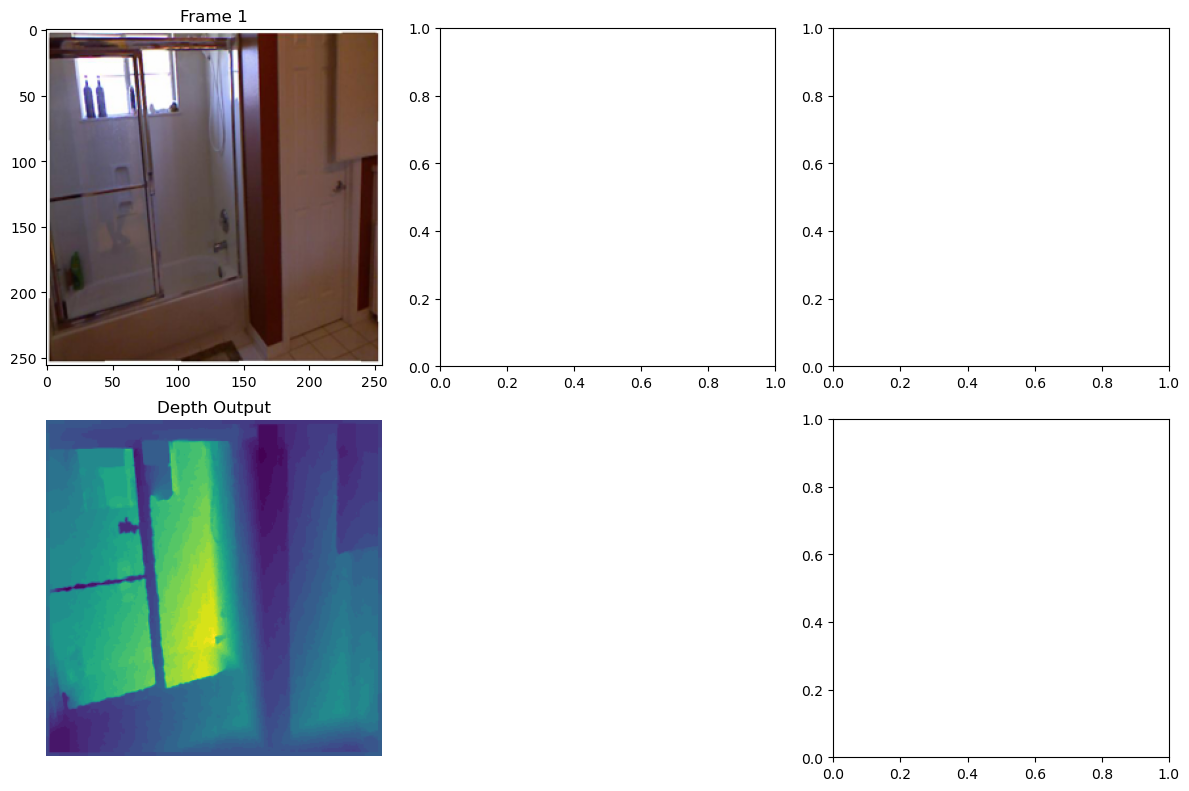

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

gen = data_generator(imageData, depthData, validIndices, 1)
sampleImage, sampleDepth = next(gen)
print(sampleImage[0].shape)
print(sampleImage[0,0:3,0:3,0])

axes[0].imshow(sampleImage[0])
axes[0].set_title('Frame 1')
# axes[1].imshow(sampleImages[0][1])
# axes[1].set_title('Frame 2')
# axes[2].imshow(sampleImages[0][2])
# axes[2].set_title('Frame 3')
axes[3].imshow(sampleDepth[0])
axes[3].set_title('Depth Output')

for ax in axes[3:5]:
    ax.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# importing libraries to run dnn

In [28]:
def hourglass_module(x, filters):
    # First Residual Block
    x_res1 = residual_block(x, filters)

    # Downsampling
    x_downsampled = MaxPooling2D((2, 2), padding='same')(x_res1)

    # Second Residual Block
    x_res2 = residual_block(x_downsampled, filters)

    # Upsampling
    x_upsampled = UpSampling2D((2, 2))(x_res2)

    # Skip connection to the original input
    x_skip = Conv2D(filters, (1, 1), padding='same')(x)

    # Resize x_upsampled to match the shape of x_skip_resized
    x_upsampled_resized = tf.image.resize(x_upsampled, size=tf.shape(x_skip)[1:3], method='nearest')

    # Skip connection with the upsampled features
    x = Add()([x_skip, x_upsampled_resized])

    return x

def residual_block(x, filters, kernel_size=3, strides=1):
    y = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    y = Activation('relu')(y)
    y = Conv2D(filters, kernel_size, padding='same')(y)

    # Adjust the shortcut connection to match the dimensions
    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
    y = Add()([y, shortcut])

    y = Activation('relu')(y)
    return y

In [29]:
def encoder_decoder(input_shape, dropout=0.2, level_1_features=16, level_2_features=32, level_3_features=64):
    output_shape = input_shape[-1]
    # Input layer
    inputs = Input(shape=input_shape)

    # First convolution layer
    conv1 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(inputs)
    conv1 = Dropout(dropout)(conv1)

    # Second convolution layer
    conv2 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(conv1)
    conv2 = Dropout(dropout)(conv2)
#     conv2 = Activation('relu')(conv2)

    # Third convolution layer
    conv3 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(conv2)
    conv3 = Dropout(dropout)(conv3)
#     conv3 = Activation('relu')(conv3)
    conv4Input = Add()([conv3, conv1])

    # Fourth convolution layer with a residual connection
    conv4 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(conv4Input)
    conv4 = Dropout(dropout)(conv4)
#     conv4 = Activation('relu')(conv4)
    
    #Max pooling after conv4
    conv4_pooled = MaxPooling2D((2, 2))(conv4)

    # fifth convolution layer 
    conv5 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(conv4_pooled)
    conv5 = Dropout(dropout)(conv5)
#     conv5 = Activation('relu')(conv5)
    
    # sixth convolution layer 
    conv6 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(conv5)
    conv6 = Dropout(dropout)(conv6)
#     conv6 = Activation('relu')(conv6)
    
    conv7Input = Add()([conv6, conv4_pooled])
    
    # seventh convolution layer with a residual connection
    conv7 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(conv7Input)
    conv7 = Dropout(dropout)(conv7)
#     conv7 = Activation('relu')(conv7)
    
    #Max pooling after conv7
    conv7_pooled = MaxPooling2D((2, 2), padding='same')(conv7)
    
    # eight convolution layer 
    conv8 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(conv7_pooled)
    conv8 = Dropout(dropout)(conv8)
#     conv8 = Activation('relu')(conv8)
    
    # nineth convolution layer 
    conv9 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(conv8)
    conv9 = Dropout(dropout)(conv9)
#     conv9 = Activation('relu')(conv9)
    
    conv10Input = Add()([conv9, conv7_pooled])
    
    #tenth convolutional layer with residual connection
    conv10 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(conv10Input)
    conv10 = Dropout(dropout)(conv10)
#     conv10 = Activation('relu')(conv10)
    
    #max pooling after conv10
    conv10_pooled = MaxPooling2D((2, 2), padding='same')(conv10)
    
    #This needs to fed into the Hour Glass
    
#     hourGlass1Output = hourglass_module(conv10_pooled, 64)
       # Stacked Hourglass
    hourglass = conv10_pooled
    for _ in range(4):  # You can adjust the number of stacked hourglass modules
        hourglass = hourglass_module(hourglass, 128) 
        
    for _ in range(4):  # You can adjust the number of stacked hourglass modules
        hourglass = hourglass_module(hourglass, 128) 
        

    dec_conv1 = UpSampling2D((2, 2))(hourglass)
    
    dec_conv2 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(dec_conv1) # this output gets added to output of conv 4
    dec_conv2 = Dropout(dropout)(dec_conv2)

    dec_conv3 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(dec_conv2)
    dec_conv3 = Dropout(dropout)(dec_conv3)
    
    dec_conv4 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(dec_conv3)
    dec_conv4 = Dropout(dropout)(dec_conv4)
    
    dec_conv5Input = Add()([dec_conv4, dec_conv2])
    
    dec_conv5 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(dec_conv5Input)
    dec_conv5 = Dropout(dropout)(dec_conv5)
    dec_conv6 = UpSampling2D((2, 2))(dec_conv5) # add this to output of conv 8
    
    dec_conv7 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(dec_conv6)
    dec_conv7 = Dropout(dropout)(dec_conv7)
    dec_conv8 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(dec_conv7)
    dec_conv8 = Dropout(dropout)(dec_conv8)
    
    dec_conv9Input = Add()([dec_conv8, dec_conv6])
    
    dec_conv9 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(dec_conv9Input)
    dec_conv9 = Dropout(dropout)(dec_conv9)
    dec_conv10 = UpSampling2D((2, 2))(dec_conv9) # add this to output of conv 12

    dec_conv11 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(dec_conv10)
    dec_conv11 = Dropout(dropout)(dec_conv11)
    dec_conv12 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(dec_conv11)
    dec_conv12 = Dropout(dropout)(dec_conv12)
    
    dec_conv13Input = Add()([dec_conv12, dec_conv10])

    dec_conv13 = Conv2D(1, (3, 3), padding='same', activation='relu')(dec_conv13Input)
    dec_conv13 = Dropout(dropout)(dec_conv13)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=dec_conv13)
    return model

# checking that the encoder_decoder is working

In [30]:
# Getting Model dimensions
input_shape = (256, 256, 3)  # Adjust input shape as needed
model = encoder_decoder(input_shape, dropout=0.2)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 256, 256, 16  448         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_40 (Dropout)           (None, 256, 256, 16  0           ['conv2d_152[0][0]']             
                                )                                                           

# Training the Model

In [31]:
from sklearn.model_selection import train_test_split

# Split indices into training and validation sets
train_indices, val_indices = train_test_split(validIndices, test_size=0.2)

# Create two generators
train_gen = data_generator(imageData, depthData, train_indices, 12)
val_gen = data_generator(imageData, depthData, val_indices, 12)

(256, 256, 3)
[[0.99215686 0.9882353  0.9843137 ]
 [0.9882353  0.9843137  0.9843137 ]
 [0.9882353  0.99607843 0.9529412 ]]
1.0 0.0
(256, 256)
[[0.20784314 0.20784314 0.20784314]
 [0.20784314 0.20784314 0.20784314]
 [0.20784314 0.20784314 0.20784314]]
1.0 0.0


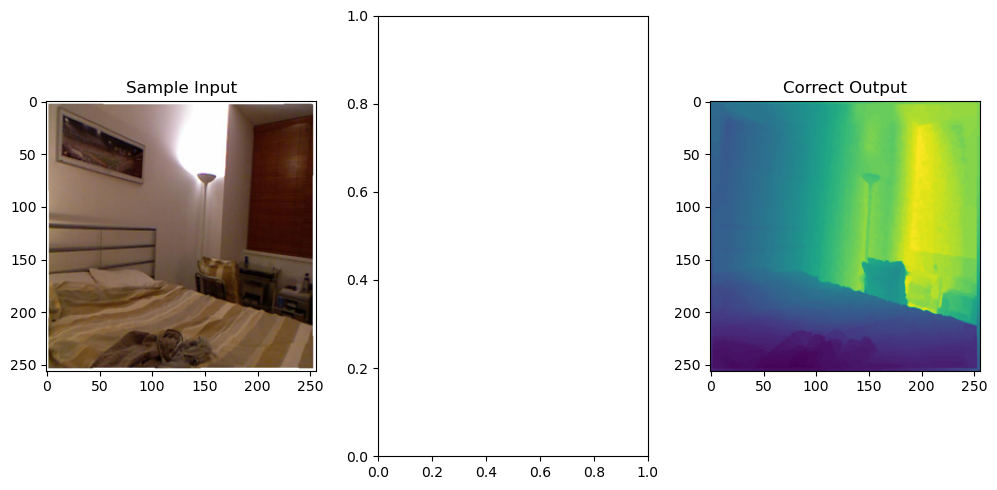

In [32]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and 'imageData' contains your input images
sampleImages, sampleDepth = next(train_gen)

sampleImages = sampleImages[0]
print(sampleImages.shape)
print(sampleImages[0:3,0:3,0])
print(f"{np.max(sampleImages)} {np.min(sampleImages)}")
sampleDepth = sampleDepth[0]
print(sampleDepth.shape)
print(sampleDepth[0:3,0:3])
print(f"{np.max(sampleImages)} {np.min(sampleImages)}")

# Display the input and output images
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes = axes.flatten()

# Visualizing the input
axes[0].imshow(sampleImages)
axes[0].set_title('Sample Input')

axes[2].imshow(sampleDepth)
axes[2].set_title('Correct Output')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [37]:
optim = Adam(learning_rate = 0.0005)

# model.compile(optimizer=optim, loss=MeanSquaredError())
# model.fit(dataset, epochs=5, steps_per_epoch=20)

model.compile(optimizer=optim, loss=paperLoss)
model.fit(dataset, epochs=3, steps_per_epoch=5)

# for epoch in range(20):
#     print(f"\n\nEpoch {epoch}:")
#     for batch in range(20):
#     # for sampleImage, sampleDepth in gen:
#         print(f"Batch {batch}:   ", end="")
#         sampleImage, sampleDepth = next(gen)
#         model.fit(sampleImage, sampleDepth)


Epoch 1/3


TypeError: in user code:

    File "c:\Users\Aidan\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Aidan\AppData\Local\Temp\ipykernel_8152\2354652563.py", line 38, in paperLoss  *
        mseLoss = MeanSquaredError(y_true, y_pred).numpy()
    File "c:\Users\Aidan\miniconda3\envs\tf\lib\site-packages\keras\losses.py", line 361, in __init__  **
        super().__init__(mean_squared_error, name=name, reduction=reduction)
    File "c:\Users\Aidan\miniconda3\envs\tf\lib\site-packages\keras\losses.py", line 250, in __init__
        super().__init__(reduction=reduction, name=name)
    File "c:\Users\Aidan\miniconda3\envs\tf\lib\site-packages\keras\losses.py", line 94, in __init__
        losses_utils.ReductionV2.validate(reduction)
    File "c:\Users\Aidan\miniconda3\envs\tf\lib\site-packages\keras\utils\losses_utils.py", line 87, in validate
        if key not in cls.all():

    TypeError: Expected float32 passed to parameter 'y' of op 'Equal', got 'auto' of type 'str' instead. Error: Expected float32, but got auto of type 'str'.


1/1 [==============================] - 0s 421ms/step
(256, 256, 1)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
0.00893058069050312 0.0


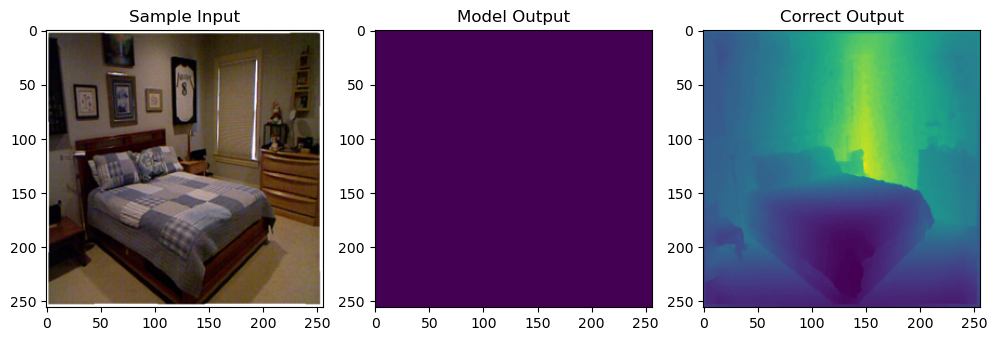

In [36]:
import matplotlib.pyplot as plt


# Get the model's prediction
image, depth = next(val_gen)
samplePrediction = model.predict(image)

samplePrediction = samplePrediction[0]  # Remove the batch dimension
print(samplePrediction.shape)
print(samplePrediction[0:3,0:3,0])
print(f"{np.max(samplePrediction)} {np.min(samplePrediction)}")


# Display the input and output images
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes = axes.flatten()

# Visualizing the input
axes[0].imshow(image[0])
axes[0].set_title('Sample Input')

# Visualizing the output
# Assuming the output is a depth map with a single channel
# sample_output_image = np.squeeze(sample_output, axis=0)  # Remove batch dimension
# if sample_output_image.shape[-1] == 1:  # If output has a single channel
# samplePrediction = (samplePrediction[0]*255).astype(int)  # Remove the channel dimension
axes[1].imshow(samplePrediction)  # You might need to adjust the color map
axes[1].set_title('Model Output')

axes[2].imshow(depth[0])
axes[2].set_title('Correct Output')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [ ]:
# for data, labels in dataset.take(1):  # Take one batch from the dataset
#     print(f'Data shape: {data.shape}')
#     print(f'Labels shape: {labels.shape}')

In [ ]:


# # sampleImages, sampleDepth = next(gen)
# # # temp_sampleImages, resized_sampleDepth =  preprocess_data(sampleImages, sampleDepth)
# # temp_sample_images = sampleImages[:, 0, :, :]  # Slicing the tensor as per your requirement

# # # Assuming depth_data has shape (batch_size, 256, 256)
# # resized_sample_depth = tf.expand_dims(sampleDepth, axis=-1)  # Add the missing dimension

# # # Now resized_sample_depth has shape (batch_size, 256, 256, 1)

# # # Replicate the single channel across three channels
# # resized_sample_depth = tf.concat([resized_sample_depth] * 3, axis=-1)

# optim = Adam(learning_rate = 0.001)

# # # Compile the model
# model.compile(optimizer=optim, loss=MeanSquaredError())
# model.fit(dataset, epochs=10, steps_per_epoch=8)

# # # Train the model
# # model.fit(temp_sample_images, resized_sample_depth, epochs=20, steps_per_epoch=20, batch_size=__BATCHSIZE__, validation_split=0.2)


In [ ]:
# # Define the model
# input_shape = (256, 256, 3)
# model = encoder_decoder(input_shape)



# # Compile the model
# model.compile(optimizer=Adam(), loss=MeanSquaredError())

# # Train the model
# model.fit(temp_sampleImages, resized_sampleDepth, epochs=10, batch_size=8, validation_split=0.2)

# # # Save the trained model
# # model.save("encoder_decoder_model.h5")